In [1]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib
from itertools import combinations
from tqdm import tqdm
import random
from collections import defaultdict
import itertools

In [2]:
mydict = torch.load("circuitDict.pt")

In [4]:
def tablePadding(truthTable):
    #Takes a truthtable and adds rows to fix row amount to 16.
    rows = truthTable.shape[0]

    padding = torch.full((16 - rows, truthTable.shape[1]), 2.0)
    return torch.cat((truthTable, padding), dim=0).long()

In [5]:
coloum1 = [0, 1, 0, 1]
coloum2 = [0, 0, 1, 1]

AND = [0,0,0,1]
OR = [0,1,1,1]
XOR = [0,1,1,0]
NAND = [1,1,1,0]
NOR = [1,0,0,0]
XNOR = [1,0,0,1]

In [46]:
# Inputs
col1 = torch.tensor([0, 1, 0, 1])
col2 = torch.tensor([0, 0, 1, 1])

# Gates
gates = {
    'AND':  torch.logical_and(col1, col2).int(),
    'OR':   torch.logical_or(col1, col2).int(),
    'XOR':  torch.logical_xor(col1, col2).int(),
    'NAND': (~torch.logical_and(col1, col2)).int(),
    'NOR':  (~torch.logical_or(col1, col2)).int(),
    'XNOR': (~torch.logical_xor(col1, col2)).int(),
}

input_indices = list(itertools.permutations(range(4), 2))
output_indices = list(range(4))

results = []
metadata = []  # <--- NEW: store metadata

for gate_name, gate_output in gates.items():
    for in1, in2 in input_indices:
        for out_idx in output_indices:
            inputs = torch.full((4, 4), 2)
            inputs[:, in1] = col1
            inputs[:, in2] = col2

            middle = torch.full((4, 4), 2)

            outputs = torch.full((4, 4), 2)
            outputs[:, out_idx] = gate_output

            full_table = torch.cat([inputs, middle, outputs], dim=1)  # [4, 12]
            results.append(tablePadding(full_table))

            # Save the gate used, inputs used, and output column
            metadata.append({
                'gate': gate_name,
                'input_cols': (in1, in2),
                'output_col': out_idx
            })

# Stack results
final_tensor = torch.stack(results)  # Shape: [288, 4, 12]
print(final_tensor.shape)

torch.Size([288, 16, 12])


In [47]:
numpyGates = final_tensor.numpy()
generated_bytes = [table.tobytes() for table in numpyGates]
len(generated_bytes)

288

In [50]:
# Step 2: Now compare each dataset item to the generated bytes
matches = []
for i, item_bytes in enumerate(mydict):
    if item_bytes in generated_bytes:
        match_idx = generated_bytes.index(item_bytes)
        matches.append((i, match_idx))  # (index in dataset, index in generated tables)

# Now `matches` contains tuples of matching indices
print("Matching entries:", matches)

Matching entries: [(0, 0), (1, 1), (2, 162), (3, 163), (4, 210), (5, 215), (8, 48), (9, 198), (10, 203), (13, 195), (16, 194), (29, 4), (36, 211), (40, 52), (45, 199), (50, 193), (81, 227), (181, 214), (183, 209), (203, 226), (340, 202), (365, 178), (456, 197), (551, 166), (620, 179), (693, 167), (1009, 155), (1010, 154), (1133, 225), (1326, 213), (1353, 8), (1997, 196), (2623, 201), (2684, 57), (2739, 145), (2832, 150), (2842, 192), (2859, 151), (3646, 161), (3739, 70), (4426, 82), (4504, 50), (4640, 22), (4995, 208), (5338, 66), (5382, 9), (5535, 177), (5832, 224), (5835, 152), (6047, 5), (6090, 65), (6115, 49), (6124, 56), (6182, 81), (6223, 212), (6248, 21)]


In [53]:
for j in matches:
    #print(j[1])
    matched_metadata = metadata[j[1]]
    print(matched_metadata, j)

{'gate': 'AND', 'input_cols': (0, 1), 'output_col': 0} (0, 0)
{'gate': 'AND', 'input_cols': (0, 1), 'output_col': 1} (1, 1)
{'gate': 'NAND', 'input_cols': (1, 2), 'output_col': 2} (2, 162)
{'gate': 'NAND', 'input_cols': (1, 2), 'output_col': 3} (3, 163)
{'gate': 'NOR', 'input_cols': (1, 2), 'output_col': 2} (4, 210)
{'gate': 'NOR', 'input_cols': (1, 3), 'output_col': 3} (5, 215)
{'gate': 'OR', 'input_cols': (0, 1), 'output_col': 0} (8, 48)
{'gate': 'NOR', 'input_cols': (0, 2), 'output_col': 2} (9, 198)
{'gate': 'NOR', 'input_cols': (0, 3), 'output_col': 3} (10, 203)
{'gate': 'NOR', 'input_cols': (0, 1), 'output_col': 3} (13, 195)
{'gate': 'NOR', 'input_cols': (0, 1), 'output_col': 2} (16, 194)
{'gate': 'AND', 'input_cols': (0, 2), 'output_col': 0} (29, 4)
{'gate': 'NOR', 'input_cols': (1, 2), 'output_col': 3} (36, 211)
{'gate': 'OR', 'input_cols': (0, 2), 'output_col': 0} (40, 52)
{'gate': 'NOR', 'input_cols': (0, 2), 'output_col': 3} (45, 199)
{'gate': 'NOR', 'input_cols': (0, 1), 'ou

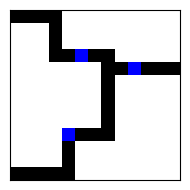

tensor([[0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2],
        [1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2],
        [0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2],
        [1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])


In [70]:
#mydict
def printCircuit(circuit):
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    fig, ax = plt.subplots(figsize=(2, 2))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(circuit, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    plt.tight_layout()
    plt.show()


testID = 9
probabilityCircuit = mydict[generated_bytes[testID]][0]
argmaxCircuit = torch.argmax(probabilityCircuit, dim=0, keepdim=False).cpu().numpy()

printCircuit(argmaxCircuit)
print(final_tensor[testID])